# Probing Density

In [1]:
import matplotlib.pyplot as plt
import random
from scipy.stats import skew
import numpy as np
random.seed(1337)

On a 1-dimensional interval [0,1] there exists $n$ points. We know nothing the distribution of dots or how many of them there are. However, we do know that there's a minimum distance $d$ between the dots. This is given to us as prior information.

We have one tool to our disposal: a probe. We can give the probe a position $x \in [0,1]$ and it will return the coordinates to the closest left and right dots. We define it as $probe(x): x \in [0,1] \rightarrow (l,r)$ where $l,r \in [0,1]$.

Our task is to approximate the number of dots that's present in the interval. Remember that we can assume nothing about the distribution of dots, as they are placed *arbitrarily*.

### The Probe Function
The probe function looks through the list of (sorted) generated dots and finds the dots left and right of the probed position.

In [2]:
def probe(x, dots):
    N = len(dots)
    for i, dot in enumerate(dots[:-1]):
        if x > dot:
            continue
        else:
            if i - 1 < 0:
                l = None
                r = dots[i]
            else:
                l = dots[i]
                r = dots[i+1]

            return (l,r)
            
    # If we get to the end there's no dots left of x
    return (dots[-1], None)

In [3]:
def get_avg_dist(dots):
    dots.sort()
    intervals = [(i,j) for i,j in zip(dots, dots[1:])]
    dists = np.array([intv[1]-intv[0] for intv in intervals])
    return dists.mean()

## The Intervals

Let's visualize the interval with dots by placing 100 dots in a random fashion. With the contraint that a point cannot be closer than $d$ from any other point. We'll set $d = 0.05$ for now 

In [4]:
N = 100
d = 1
x_max = 1000
def generate_dots(N, d, distribution_fn):
    dots = []
    seen = set()
    for i in range(N):
        # not the most efficient but will do for now
        dots.sort()
        x = distribution_fn()
        while x in seen:
             x = distribution_fn()
                
        seen.add(x)
        dots.append(x)
    return dots

In [5]:
def plot_interval(dots, title='Our beautiful interval', x_max = 1000):
    N = len(dots)
    y = [0 for i in range(N)]
    plt.figure(figsize=(20,8))
    plt.hlines(0,0, x_max, alpha=0.3)
    plt.scatter(dots, y, s=50, facecolors='none', edgecolors='r', label='N = %d' % (N))
    plt.title(title)
    plt.legend()
    plt.show()

### Uniform Interval

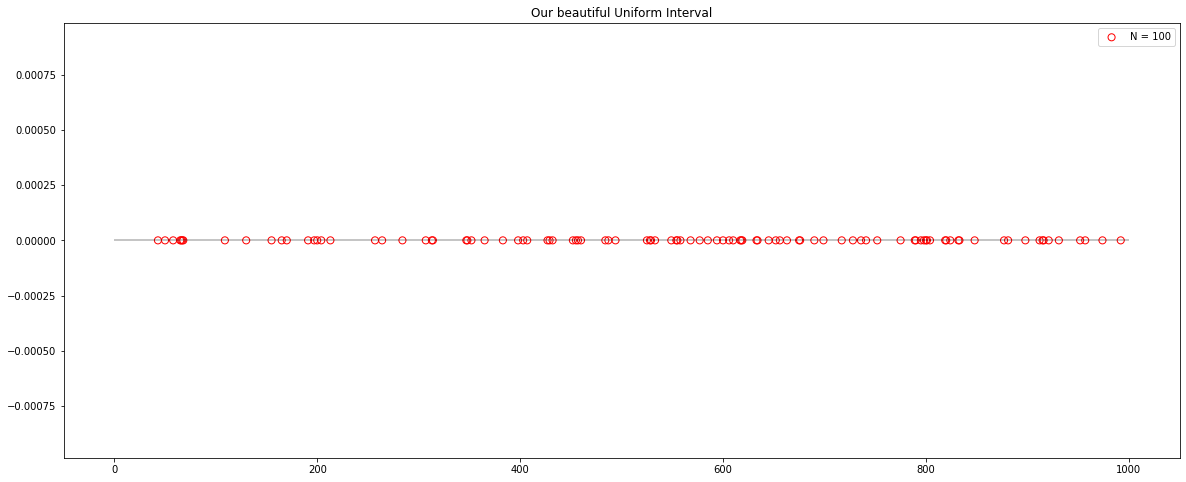

Variance over the whole line:  68573.5684


In [6]:
def custom_randunif():
    return int(random.uniform(0, x_max))

dots = generate_dots(N,d, custom_randunif)
plot_interval(dots, title='Our beautiful Uniform Interval')
print("Variance over the whole line: ", np.var(dots))

### Gaussian Interval

Let's make an interval with normally distributed points

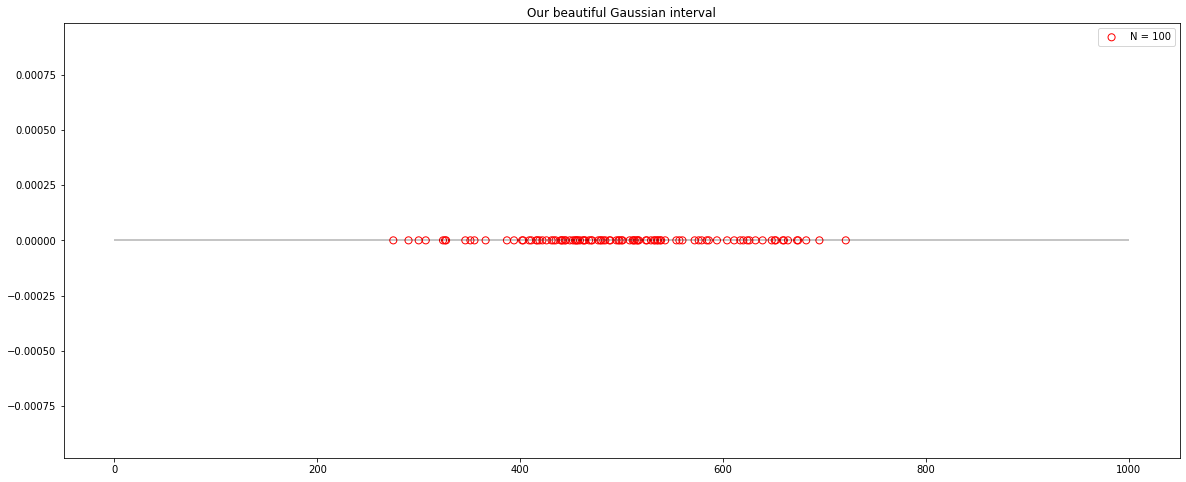

Variance over the whole line:  10009.1724


In [7]:
def custom_gaussian():
    return int(random.gauss(x_max//2, x_max // 10))

dots_gauss = generate_dots(N,d, custom_gaussian)
plot_interval(dots_gauss, "Our beautiful Gaussian interval")
print("Variance over the whole line: ", np.var(dots_gauss))

### Clusters Interval

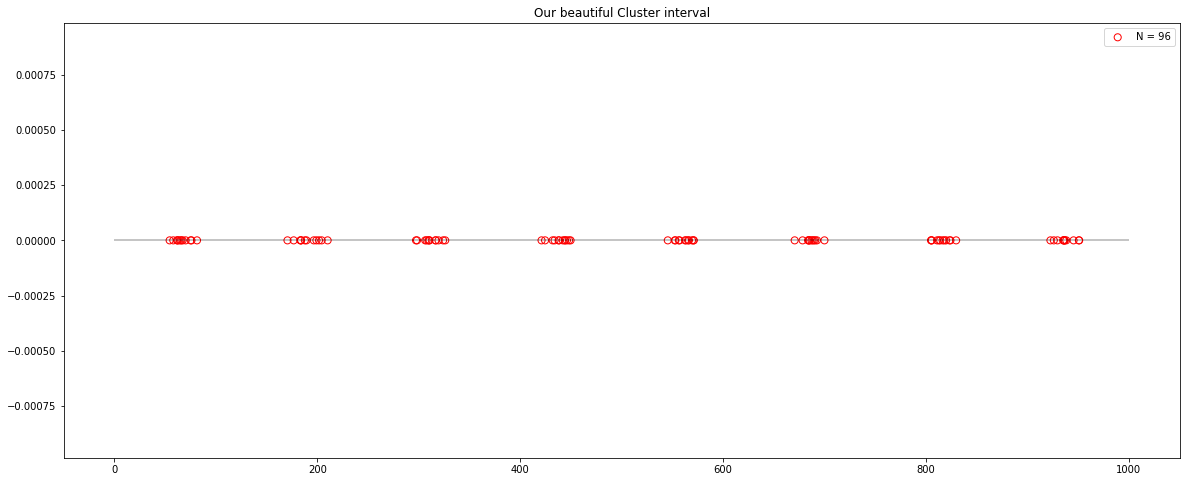

Variance over the whole line:  81501.87097675056


In [31]:
def generate_clustrs(N, d, num_clusters = 8, std=10):
    mu_range = np.arange(x_max//(num_clusters*2),x_max,x_max//num_clusters)
    dots_clustrs = []
    for i in range(num_clusters):
        def custom_clustrs():
            return random.gauss(mu_range[i], std)
            generate_dots(N//num_clusters,d, custom_clustrs1)

        clust = generate_dots(N//num_clusters, d, custom_clustrs)
        dots_clustrs.append(clust)

    dots_clustrs = np.array(dots_clustrs).flatten()
    return dots_clustrs

dots_clustrs = generate_clustrs(N, d, num_clusters=8)
plot_interval(dots_clustrs, "Our beautiful Cluster interval")
print("Variance over the whole line: ", np.var(dots_clustrs))

Let's create a function for which we can specify a number of dots and a type of distribution

In [9]:
def create_dots_distr(N, type='uniform'):
    d = (x_max / N) * 0.1
    if type == 'uniform':
        return generate_dots(N,d, custom_randunif)
    if type == 'gaussian':
        return generate_dots(N,d, custom_gaussian)
    if type == 'clusters':
        return generate_clustrs(N, d)

## A Simple Randomized Approach

One metric is the mean distance between points, $\bar{d}$. The inverse of $\bar{d}$ can be used to approximate the number of points $\bar{n} = 1 / \bar{d}$. 

One approach is to simply probe the line $k$ times and try to get a mean distance between the dots.

In [10]:
import numpy as np

def simple_probing(dots, k, a, b):
    distances = []
    dots.sort()
    
    for i in range(k):
        x = random.uniform(a,b)
        l,r = probe(x, dots)
        # For now we skip edges
        if l and r:
            d = r - l
            distances.append(d)

    if len(distances):
        dists = np.array(distances)
        d_mean = dists.mean()
        return (b-a) / d_mean, d_mean
    else:
        return 0, 0


Let's run the simple probing algorithm and see some approximations

### Simple Randomized Approach on Uniform Interval

In [11]:
approximations = []
for i in range(x_max):
    n_approx, _ = simple_probing(dots, 100, 0, x_max)
    approximations.append(n_approx)

aprx = np.array(approximations)

Sample Distribution Mean: 104.55
Sample Distribution STD: 9.54


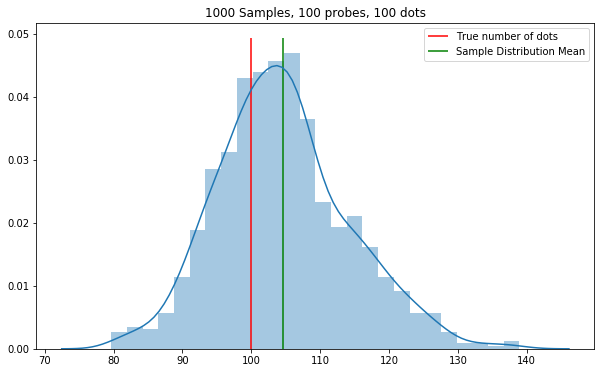

In [12]:
import seaborn as sns
def plot_sample_dist(aprx, N, n_probes=100):
    plt.figure(figsize=(10,6))
    sd_mean = aprx.mean();
    sd_std = aprx.std();
    print("Sample Distribution Mean: %.2f" % sd_mean)
    print("Sample Distribution STD: %.2f" % sd_std)
    sns.distplot(aprx);
    ylim = plt.gca().get_ylim()
    line_height = ylim[1]
    plt.vlines(N, 0, line_height, colors='r', label='True number of dots')
    plt.vlines(aprx.mean(), 0, line_height, colors='g', label='Sample Distribution Mean')
    plt.legend()
    plt.title('%d Samples, %d probes, %d dots' % (aprx.size, n_probes, N))
    plt.show()

plot_sample_dist(aprx, N)

Looks pretty neat! The barplot makes it look like we're ways off, but in reality we are not.

### Simple Randomized Approach on Gaussian dots

Sample Distribution Mean: 180.46
Sample Distribution STD: 28.39


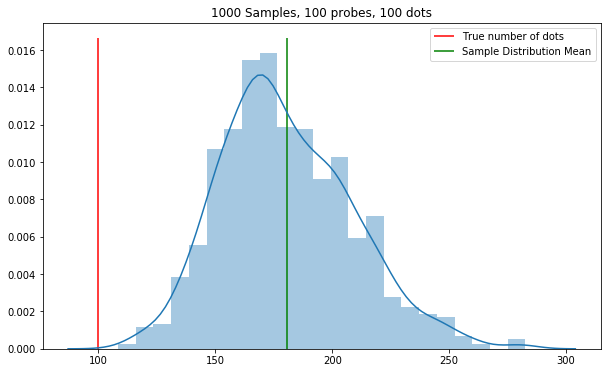

In [13]:
approximations = []
for i in range(1000):
    n_approx, _ = simple_probing(dots_gauss, 100, 0, x_max)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, 100)

We're beginning to see some issues with the algorithm. The error rate is around 20 %

### Simple Randomized Approach on Clustered dots

Sample Distribution Mean: 195.56
Sample Distribution STD: 97.94


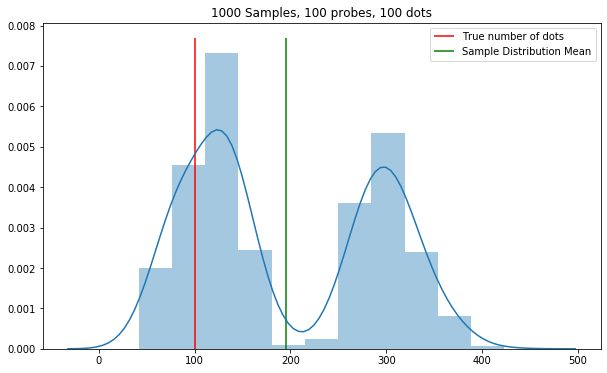

In [14]:
approximations = []
for i in range(1000):
    n_approx, _ = simple_probing(dots_clustrs, 100, 0, x_max)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, 100)

## Interval Inception

Let's try to divide the interval into... more intervals! Using the metric of mean distance between points might not be useful if we are considering the whole interval.

Let's divide the main interval into $m$ subintervals and probe each of them separately.

In [15]:
def create_intervals(m):
    step = x_max / m
    interval_borders = np.arange(0, x_max + step, step)
    intervals = [(i,j) for i,j in zip(interval_borders, interval_borders[1:])]
    return intervals

def get_dots_in_intervals(dots, intervals):
    dots.sort()
    dots_ix = 0
    spans = []
    dots_in_intervals = []
    for intv in intervals:
        dots_in_interval = []
        for dot in dots:
            if dot >= intv[0] and dot < intv[1]:
                dots_in_interval.append(dot)
        
        dots_in_intervals.append(dots_in_interval)
        
   
    return dots_in_intervals

def get_number_dots_in_intervals(dots_in_intervals):
    return [len(intv) for intv in dots_in_intervals]

def get_intervals_mean_densities(dots_in_intervals):
    interval_density_means = []
    for intv_dots in dots_in_intervals:
        if len(intv_dots) > 1:
            intv_dots = np.array(intv_dots)
            dists = intv_dots[1:] - intv_dots[:-1]
            interval_density_means.append(dists.mean())
        elif len(intv_dots) == 1:
            interval_density_means.append(-1)
        else:
            interval_density_means.append(0)
        
    return interval_density_means
        
def get_approximations_from_densities(intverval_mean_densities, interval_length):
    approximations = []
    for d_mean in intverval_mean_densities:
        if d_mean == 0:
            approximations.append(0)
        elif d_mean == -1:
            approximations.append(1)
        else:
            approximations.append(interval_length / d_mean)
    return approximations

In [33]:
N = 100
d = 1
dots = dots_gauss = generate_dots(N,d, custom_randunif)
dots_gauss = dots_gauss = generate_dots(N,d, custom_gaussian)
dots_clustrs = generate_clustrs(N, d, num_clusters=5)

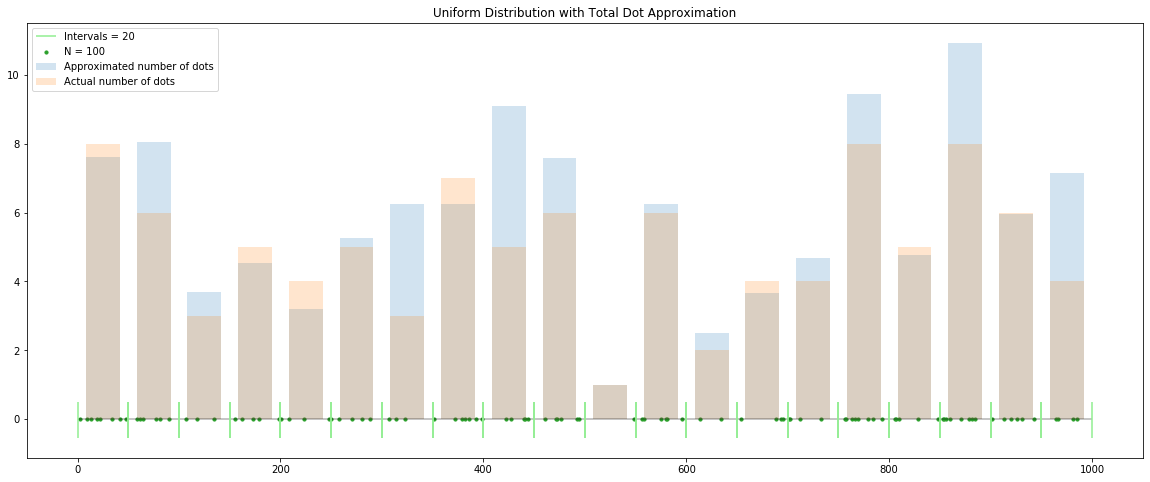

Approximation:  117.89382285543822  Real number:  100
Error:  17.893822855438216


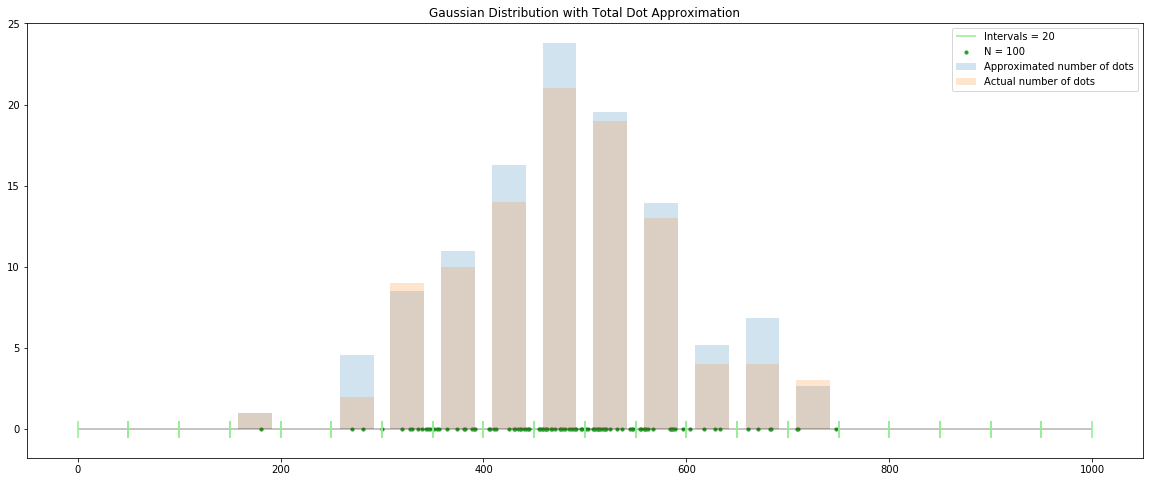

Approximation:  113.2321067309993  Real number:  100
Error:  13.232106730999305


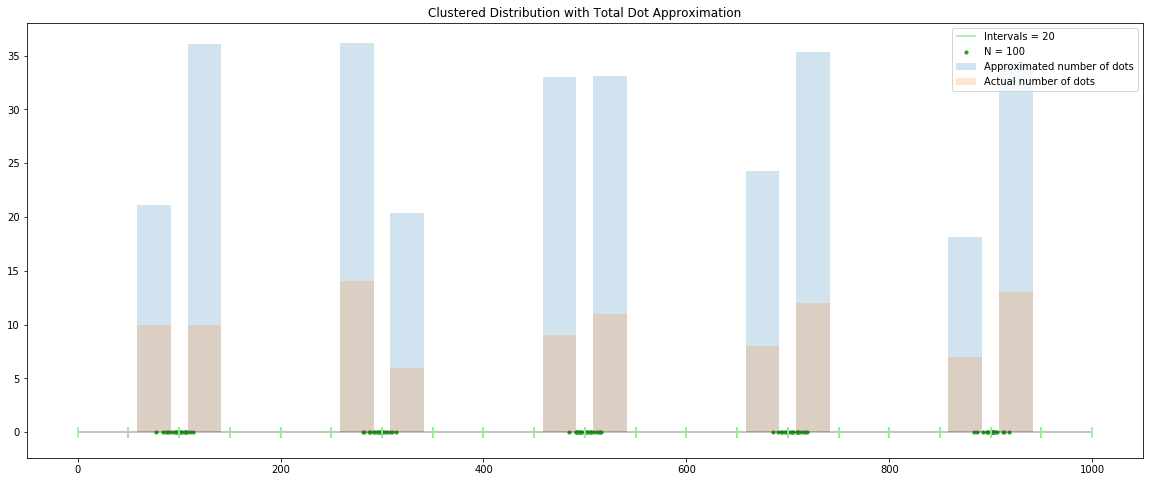

Approximation:  291.9347262415092  Real number:  100
Error:  191.93472624150922


In [34]:
def create_interval_density_plot(dots, title="Inverse Density function", n_intervals=10):
    intervals = create_intervals(n_intervals)
    dots_in_intervals = get_dots_in_intervals(dots, intervals)
    mean_densities = get_intervals_mean_densities(dots_in_intervals)
    N_approximations = get_approximations_from_densities(mean_densities, x_max / n_intervals)
    interval_means = [r - (x_max / n_intervals / 2) for l,r in intervals]
    actual_num_dots_in_intervals = get_number_dots_in_intervals(dots_in_intervals)
    
    N = len(dots)
    y = [0 for i in range(N)]
    plt.figure(figsize=(20,8))
    plt.hlines(0,0, x_max, alpha=0.3)
    
    max_density = np.max(mean_densities)
    
    plt.bar(interval_means, N_approximations, width = x_max/(n_intervals+10), alpha=0.2, label='Approximated number of dots')
    plt.bar(interval_means, actual_num_dots_in_intervals, width = x_max/(n_intervals+10), alpha=0.2, label='Actual number of dots')
    plt.vlines(intervals, ymin=-0.55, ymax=0.5, colors='lightgreen', label='Intervals = %d' % (n_intervals))
    plt.title(title)
    plt.scatter(dots, y, s=10, label='N = %d' % (N))
    plt.legend()
    plt.show()
    
    print("Approximation: ",  np.sum(N_approximations) , " Real number: ", len(dots))
    print("Error: ", abs(len(dots) - np.sum(N_approximations)))

n_intervals = 20

create_interval_density_plot(dots, title="Uniform Distribution with Total Dot Approximation", n_intervals=n_intervals)
create_interval_density_plot(dots_gauss, title="Gaussian Distribution with Total Dot Approximation", n_intervals=n_intervals)
create_interval_density_plot(dots_clustrs, title="Clustered Distribution with Total Dot Approximation", n_intervals=n_intervals)


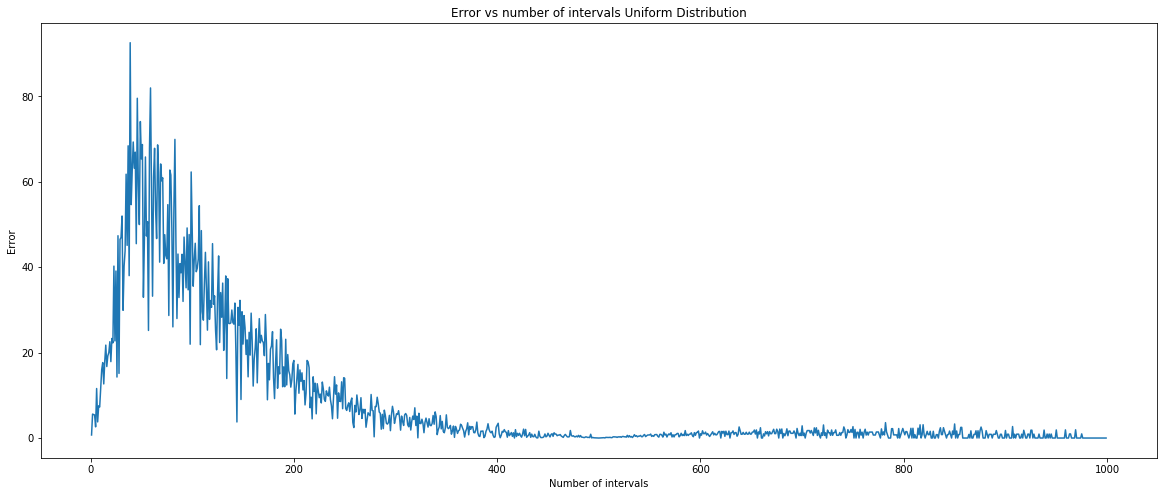

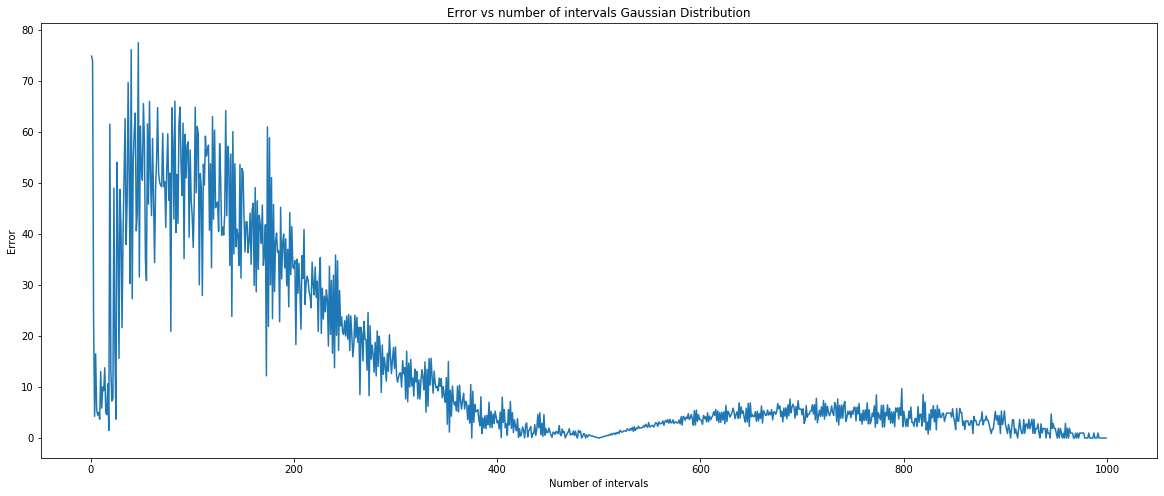

In [ ]:
def error_vs_intervals_plot(dots, title='Error vs number of intervals'):
    N = len(dots)
    interval_numbers = np.arange(1, 1000, 1)
    approximations = []
    plt.figure(figsize=(20,8))
    for n_intervals in interval_numbers:
        intervals = create_intervals(n_intervals)
        dots_in_intervals = get_dots_in_intervals(dots, intervals)
        intv_densities = get_intervals_mean_densities(dots_in_intervals)

        N_approx = get_approximations_from_densities(intv_densities, x_max / n_intervals)
        approximations.append(np.sum(N_approx))
        
    error = np.abs(np.array(approximations) - N)
    plt.plot(interval_numbers, error)
    plt.xlabel('Number of intervals')
    plt.ylabel('Error')
    plt.title(title)
    plt.show()

error_vs_intervals_plot(dots, title="Error vs number of intervals Uniform Distribution")
error_vs_intervals_plot(dots_gauss, title="Error vs number of intervals Gaussian Distribution")
error_vs_intervals_plot(dots_clustrs, title="Error vs number of intervals Clustered Distribution")